# Линейная регрессия

При изучении задач машинного обучения удобно отталкиваться от реальных данных и реальных бизнес проблем. В качестве задачи для обсуждения метода линейной регрессии мы рассмотрим сильно учененный набор данных из конкурса kaggle [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction).

Перед нами стоит задача по предсказанию цены за дом в зависимости от различных его параметров. В этом наборе данных мы для простоты специально оставим из всех парамтеров только жилую площадь в квадратных футах.

## Загрузка данных

Воспользуемся для заргузки данных из CSV файла библиотекой pandas.

In [59]:
DATASET_REDUCED_URL = 'https://gist.githubusercontent.com/sdukshis/931f187fe01468422517a09935e6623f/raw/0afe7d32f01df746804bf1f035c3bef1437c6555/kc_house_data_reduced.csv'

In [60]:
import pandas as pd

housesales = pd.read_csv(DATASET_REDUCED_URL)
housesales['price'] = housesales['price']/100000
housesales['sqft_living'] = housesales['sqft_living']/1000

## Исследование данных

Следующим шагом будет исследование данных, с которыми нам предстоит иметь дело. Самым мощным инструментов для этого является визуализация. Посмотим как цена дома зависит от его жилой площади

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


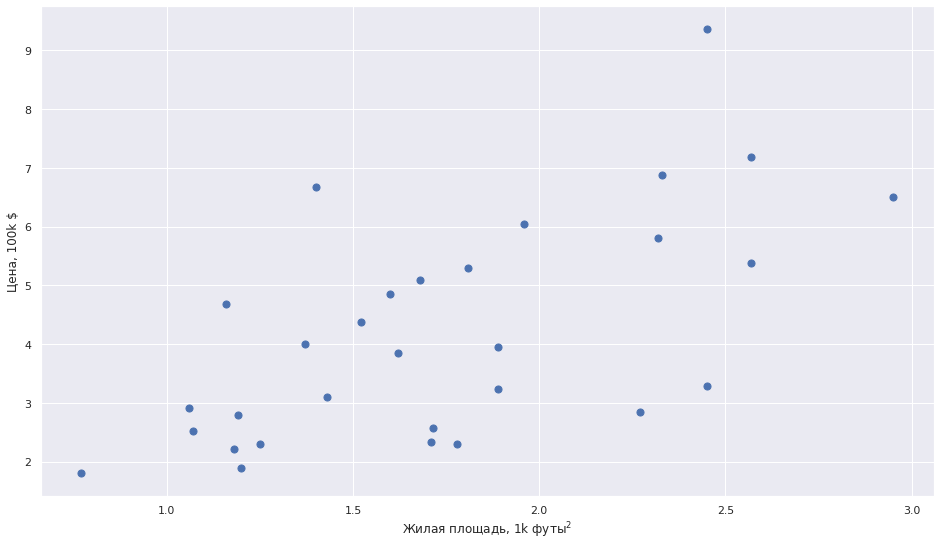

In [61]:
%matplotlib inline
import seaborn as sns  # для красивого стиля графиков
sns.set()
#from matplotlib.ticker import FuncFormatter # для форматирования разметки по оси y
ax = housesales.plot.scatter(x='sqft_living', y='price', s=50, figsize=(16,9))
ax.set_xlabel('Жилая площадь, 1k футы$^2$')
ax.set_ylabel('Цена, 100k $');

Мы видим, что точек не очень много и между жилой площадью и ценой определенно нет простой зависимости. При этом вполне логично, что есть характерная закономерность: чем больше жилая площадь, тем больше цена. В качестве более сильного предположения можно выдвинуть следующее. Если площадь увеличивается в 2 раза, то и цена увеличивается примерно в 2 раза. Это означает, что мы можем попробовать описать наблюдаемую *зависимость* как *прямо пропорциональную*, и, что еще важнее, как *линейную*.

## Постановка задачи

Важнейшим элементом *любого* исследования данных является постановка формальной задачи, которую нам предстоит решить. В данном примере она напрашивается естественным образом: *по заданной площади оценить стоимость дома*.

Например, для площади 2000 квадратных футов цена примерно может составить 500,000$.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


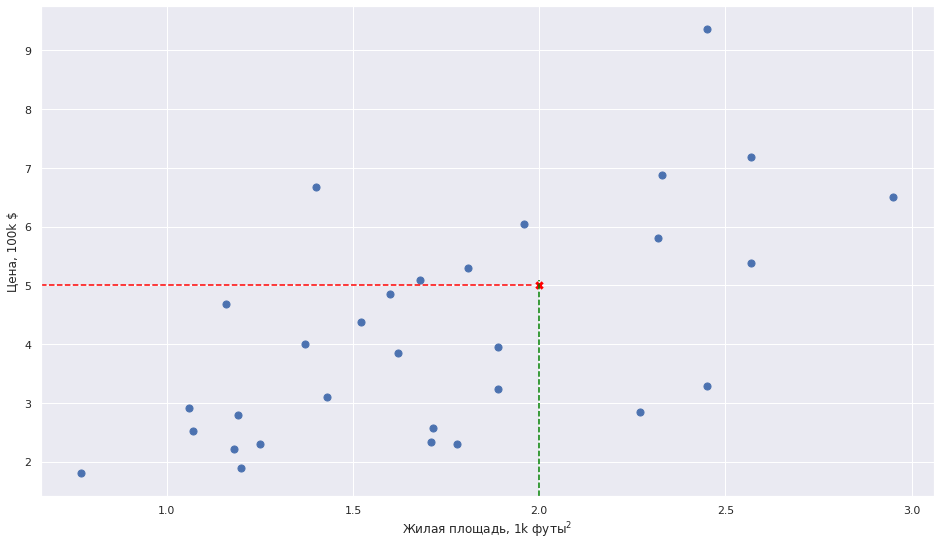

In [62]:
ax = housesales.plot.scatter(x='sqft_living', y='price', s=50, figsize=(16,9))
ax.set_xlabel('Жилая площадь, 1k футы$^2$')
ax.set_ylabel('Цена, 100k $')
ax.axvline(x=2, ymax=0.44, color='green', linestyle='--')
ax.axhline(y=5, xmax=0.55, color='red', linestyle='--')
scatter(2, 5, color='red', marker='x', s=40, linewidth=3);

## Признаки и целевая переменная

Представим наши данные в табличном виде

In [63]:
housesales.head(10)

,sqft_living,price
0,1.180,2.2190
1,2.570,5.3800
2,0.770,1.8000
3,1.960,6.0400
4,1.680,5.1000
5,1.715,2.5750
6,1.060,2.9185
7,1.780,2.2950
8,1.890,3.2300
9,1.160,4.6800


Каждоя строка состоит из двух чисел: площадь дома и его цена. Обозначим число строка как $n$

In [64]:
n = len(housesales)
n

30

Будем называть признаками те параметры, которые нам будут в задаче даны и целевыми переменными те, которые требуется определить. В данном случае у нас один признак - площадь дома и одна целевая переменная - цена. Каждую строку таблицы будем называть объектом.

Обозначим за $x^{(i)}$ - значение признака для $i$-го объекта, а за $y^{(i)}$ - значение целевой переменной для $i$-го объекта. Индекс $i$ пробегает значения от $1$ до $n$.

Пару $(x^{(i)}, y^{(i)})$ будем называть элементом обучающей выборки. A весь набор таких пар обучающей выборкой и обозначать ее как $(X, Y)$.

Следующим важным элементом является функция $h(x)$, которую называют гипотезой или моделью. В данной задаче, если на вход этой функции подать площадь дома, то на выходе должны быть вычислена примерная стоимость.

Можно грубо сказать, что все методы машинного обучения направленны на решение одного вопроса: как найти функцию $h$?

## Метрика качества

Важным элементом любой заачи машинного обучения вялется метрика качества, которая показывает насколько хорошо модель предсказывает истинный результат. В простейшем варианте для расчета метрики качества вся выборка разделяется на 2 непересекающихся подмножества: обучающую и проверочную. Обучающая используется, чтобы подобрать наилучшую гипотезу, а проверочная выборка используется для подсчета метрики качесва. Получается, что метрика качества будет оцениваться на тех объектах, которые не встречались в обучющей выборке. Такой подход позволяет проверить, насколько хорошо модель будет работать на новых примерах. 

Разделим нашу выборку на обучающую и проверочную.

In [65]:
train_size = int(0.7 * n)
test_size = n - train_size

train = housesales.iloc[:train_size]
test = housesales.iloc[train_size:]

## Коэффициент детерминации R^2

Одной из метрик, которые используются для задачи регресии является коэффициент детерминации $R^2$

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}, \quad SS_{res} = \sum\limits_{i=1}^n(y_i - \hat y_i)^2, \quad SS_{tot} = \sum\limits_{i=1}^n(y_i - \bar y)^2, \quad \bar y = \frac{1}{n}\sum\limits_{i=1}^{n}y_i.
$$

Значение этой метрики лежит в интервале от -1 до 1. Чем ближе $R^2$ к единице, тем лучше модель предсказывает истинный результат.

## Тривиальное решение

В качестве тривиального решения можно на любой вход возвращать среднее значение цены $\bar y$, посчитанное из обучающей выборки. В этом случае гипотеза примет тривиальный вид
$$
h(x) = \bar y
$$.

In [66]:
y_train_mean = train.price.mean()
y_train_mean

3.6835476190476184

Оценим нашу метрику $R^2$ для тривиального решения на проверочной выборке.

In [67]:
from sklearn.metrics import r2_score

r2_trivial = r2_score(y_true=test.price, y_pred=y_train_mean * np.ones(test_size))
r2_trivial

-0.6031098543812914

Из значения метрики видно, что тривиальная модель плохо предсказываем искомые значения. Но этот результат можно использовать как базовый, т.е. любая другая предложенная модель, должна показать лучшее значение метрики. 

## Линейная регрессия

В методе линейной регресии предлагается представить гипотезу в виде
$$
h_\theta(x) = \theta_0 + \theta_1 x.
$$

Здесь $\theta_0$ и $\theta_1$ - неизвестные вещественнозначные параметры, которые нам предстоит определить (выучить).

Рассмотрим несколько примеров для различных параметров $\theta_i$. Для простоты попложим $\theta_0= 0$.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


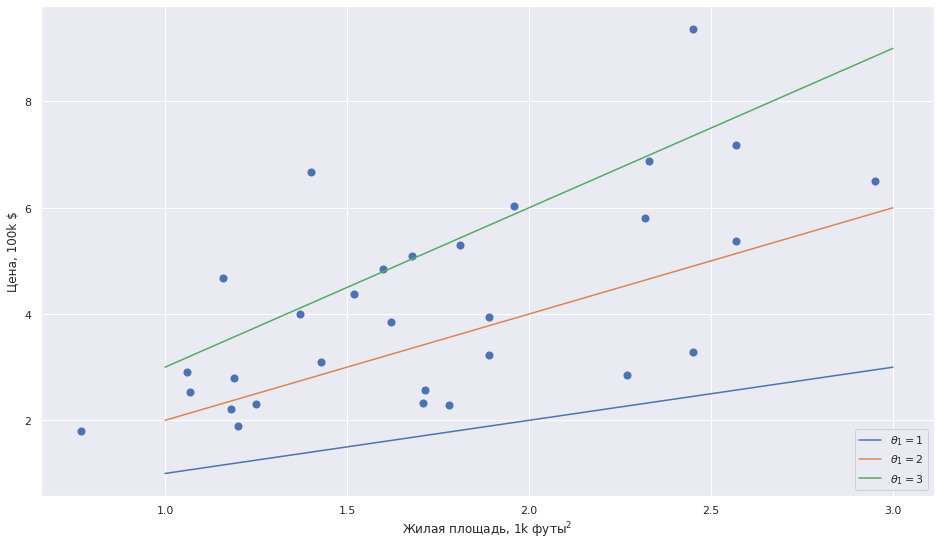

In [68]:
ax = housesales.plot.scatter(x='sqft_living', y='price', s=50, figsize=(16,9))
ax.set_xlabel('Жилая площадь, 1k футы$^2$')
ax.set_ylabel('Цена, 100k $')

xx = np.linspace(1, 3, 2)
plot(xx, 1 * xx, label='$\\theta_1 = 1$')
plot(xx, 2 * xx, label='$\\theta_1 = 2$')
plot(xx, 3 * xx, label='$\\theta_1 = 3$')
ax.legend(loc=4);

## Функция потерь

Чтобы выбрать параметры $\theta_i$ нам необходим числовой критерий $L(\theta_0, \theta_1)$. Допустим мы хотим придумать такой критерий, чтобы чем его значение меньше, тем лучшие значения параметров гипотезы мы выбрали. При этом чтобы этот критейри не принимал отрицательных значений. Это означает, что если критерий равен нулю, то мы считаем, что выбрали наилучшие из возможных значений параметров.

В методе линейно регресси в качестве такого критерий предлагается рассмотреть среднее значение квадрата ошибки.
$$
L(\theta_0, \theta_1) = \frac{1}{2n} \sum\limits_{i=1}^{n}\left(h_\theta(x^{(i)}) - y^{(i)}\right)^2. 
$$

$L$ также называют функцией потерь.

## Интуиция за функцией потерь

Чтобы пролить свет на выбор имеено такого вида функции $L$ рассмотрим упрощенный пример задачи регрессии. Обучающая выборка представлена на рисунке, а гипотеза $h$ имеет упрощенный вид
$$
h_\theta(x) = \theta_1 x
$$

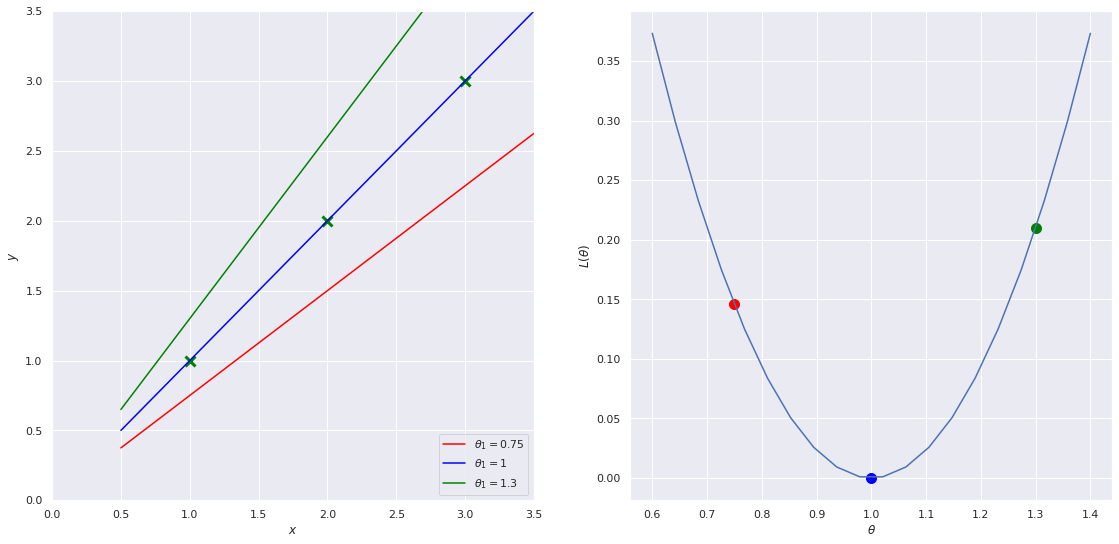

In [69]:
# Обучающая выборка
x = np.array([1, 2, 3])
y = np.array([1, 2, 3])

# Будем строить график h(x) и L(theta)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 9))

# Отметим на левом графике обучающую выборку с помощью зеленых крестиков
ax1.scatter(x, y, s=100, linewidth=3, marker='x', color='green')

# И построим график гипотезы при трех различных значениях theta
theta_1 = 0.75
theta_2 = 1
theta_3 = 1.3

xx = np.linspace(0.5, 3.5, 10)
ax1.plot(xx, theta_1*xx, color='red', label='$\\theta_1={}$'.format(theta_1))
ax1.plot(xx, theta_2*xx, color='blue', label='$\\theta_1={}$'.format(theta_2))
ax1.plot(xx, theta_3*xx, color='green', label='$\\theta_1={}$'.format(theta_3))
ax1.legend(loc=4)
ax1.set_xlim((0, 3.5))
ax1.set_ylim((0, 3.5))
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

# Определим функцию L для вычисления функции потерь
def L(x, y, theta_1):
    n = len(x)
    return 1/(2*n)*np.sum((theta_1*x - y)**2)

# И построим график функции потерь в зависимости от различных значений параметра theta_1
ax2.scatter(theta_1, L(x, y, theta_1), color='red', s=100)
ax2.scatter(theta_2, L(x, y, theta_2), color='blue', s=100)
ax2.scatter(theta_3, L(x, y, theta_3), color='green', s=100)
theta = np.linspace(0.6, 1.4, 20)
L_theta = [L(x, y, theta_1) for theta_1 in theta]
_ = ax2.plot(theta, L_theta)
ax2.set_xlabel('$\\theta$')
ax2.set_ylabel('$L(\\theta)$');

Как можно увидеть из правого графика, благодря тому, что функция $L$ имеет квадратичных вид, то у нее есть ровно один минимум, которых автоматически является глобальным. В данном примере этот минимум достугается в точке $\theta_1 = 1$.

## Метод градиентного спука

Будучи уверены, что функция $L$ имеет ровно один минимум мы можем сформулировать задачу поиска наилучшей гипотезы как задачу оптимизации, в которой необходимо минимизировать функцию потерь $L$ по параметрам гипотезы $\theta_0, \theta_1$.

\begin{equation}
\theta_0^*, \theta_1^* = \underset{\theta_0, \theta_1 \in \mathbb{R}}{\mathrm{argmin}} L(\theta_0, \theta_1).
\end{equation}

В данной поставноке мы должны минимизировать функцию сразу по двум переменным. Построим на основе нашей обучающей выборки поверхность $L(\theta_0, \theta_1)$.

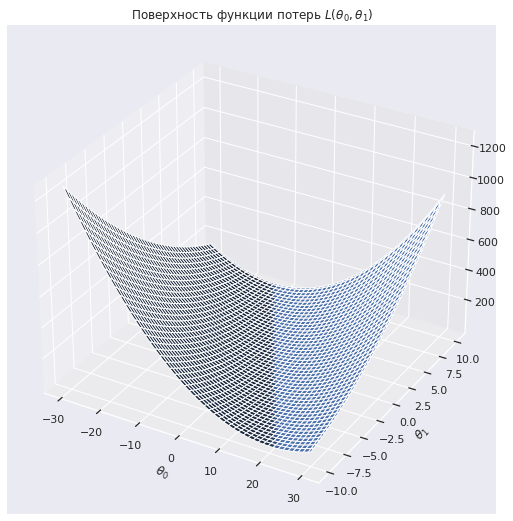

In [70]:
def L(x, y, theta_0, theta_1):
    n = len(x)
    h = theta_0 + theta_1*x
    return 1/(2*n)*np.sum((h - y)**2)

X = train['sqft_living']
y = train['price']

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

theta_0 = np.linspace(-30, 30, 100)
theta_1 = np.linspace(-10, 10, 100)
L_theta = np.array([[L(X, y, theta_0i, theta_1j) for theta_0i in theta_0] for theta_1j in theta_1])
theta_0v, theta_1v = np.meshgrid(theta_0, theta_1)


ax.plot_surface(theta_0v, theta_1v, L_theta)
plt.xlabel('$\\theta_0$')
plt.ylabel('$\\theta_1$')
plt.title('Поверхность функции потерь $L(\\theta_0, \\theta_1)$');

### Линии уровеня
Для визуального анализа график поверхности не всегда является удобным способом представления функции потерь. Для случая функции 2-х переменных удобно рассмотреть ее графическое представление в виде линий уровня - уривых, на которых функция принимает одинаковое значение.

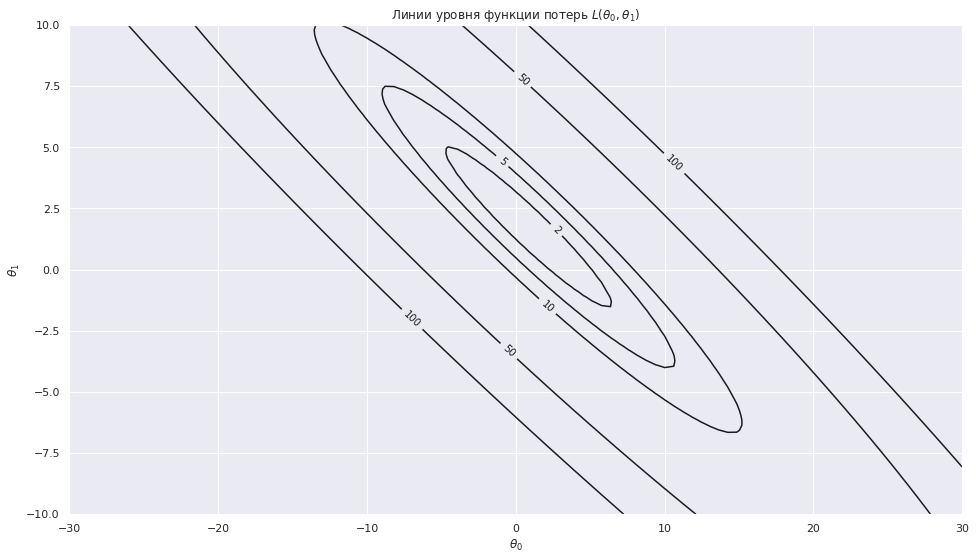

In [71]:
levels = [2, 5, 10, 50, 100]
plt.figure(figsize=(16,9))
CS = plt.contour(theta_0v, theta_1v, L_theta, levels, colors='k')
plt.clabel(CS, inline=1, fontsize=10, colors='k')
plt.xlabel('$\\theta_0$')
plt.ylabel('$\\theta_1$')
plt.title('Линии уровня функции потерь $L(\\theta_0, \\theta_1)$');

Из приведенного выше графика хорошо видно, что у функции $L$ есть всего одна точка экстремума, которая соответсвует глобальному минимум. Важный вопрос, ответ на который нам предстоит рассмотреть, заключается в том, как найти эту точку минимума. Т.е. решить задачу оптимизации или по терминологии машинного обучения - обучить модель линейной регресии.

В качестве основного метода решения мы будет использовать градиентный спуск. Напомним, что под градиентом функции в точке понимается вектор, который указывает направление наискорейшего роста функции. Компоненты вектора градиента определяеются как частные производные.

$$
grad~ L = \left(\frac{\partial L}{\partial \theta_0}, \frac{\partial L}{\partial \theta_1}\right).
$$

Для пояснение того, как метод градиентного спуска позволяет найти минимум функции, мы вернемся к одномерному случаю, когда зафиксируем $\theta_0 = 0$ и будем рассматривать зависимость функции потерь $L$ только от $\theta_1$. График этой зависимости для задачи оценки стоимост жилья приведен на рисунке ниже.

Суть метода градиентного спуска заключается в следующем. На каждом шаге мы обновляем оценку для аргумента минимума $\theta_1^{(k)}$, начиная с некоторого начального значения $\theta_1^{(0)}$ по правилу
$$
\theta_1^{(k + 1)} = \theta_1^{(k)} - \alpha \frac{\partial L}{\partial \theta_1}(\theta_1^{(k)}). 
$$

Здесь $\alpha$ - параметр, который разывают скоростью обучения (learning rate). Удачный выбор значения $\alpha$ может полохительно сказаться на числе шагов алгоритма, которые необходимы для приближения к значения минимума.

Попробуем с помощью визуализации пояснить суть работы алгоритма.

Пусть $\theta_1^{(0)} = 8$. Поскольку производная в точке описывает тангенс угла наклона касательной к функции в этой точке, то как видно из рисунка, производная будет иметь положительный знак
$$
\frac{\partial L}{\partial \theta_1}(\theta_1^{(0)}) > 0.
$$

А следовательно, производная взятая с отрицательным знаком будет направлена в сторону уменьшения значения функции $L$ и это действительно то направление, в котором следует искать минимум.

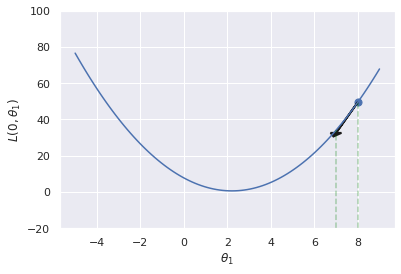

In [72]:
theta_1 = np.linspace(-5, 9, 100)
L_theta_1 = [L(X, y, 0, theta_1i) for theta_1i in theta_1]
plot(theta_1, L_theta_1)
theta1_0 = 8
scatter(theta1_0, L(X, y, 0, theta1_0), s=50)

def gradL(X, y, theta_0, theta_1):
    n = len(X)
    h = theta_0 + theta_1*X.values
    return 1/(n)*np.sum(X.transpose()@(h - y.values))

arrow(theta1_0, L(X, y, 0, theta1_0), -1, -gradL(X, y, 0, theta1_0), linewidth=2, head_width=0.5, head_length=2, fc='k', ec='k')
vlines(x=theta1_0, ymin=-20, ymax=L(X, y, 0, theta1_0), color='green', alpha=0.3, linestyles='--')
vlines(x=theta1_0 - 1, ymin=-20, ymax=L(X, y, 0, theta1_0 -1), color='green', alpha=0.3, linestyles='--')
ylim(-20, 100)
xlabel('$\\theta_1$')
ylabel('$L(0, \\theta_1)$');

Рассмотрим другую ситуацию. Пусть $\theta_1^{(0)} = -2$, тогда производная в этой точке будет иметь отрицательный знак
$$
\frac{\partial L}{\partial \theta_1}(\theta_1^{(0)}) < 0.
$$
А следовательно взятая с обратным знаком будет подталкивать значение $\theta_1^{(i)}$ вправо, что в таком случае и требуется.

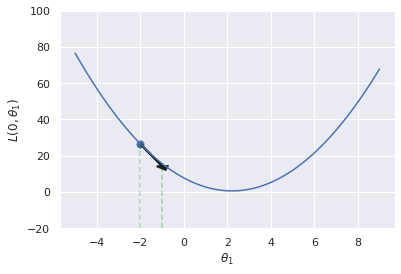

In [73]:
plot(theta_1, L_theta_1)
theta1_0 = -2
scatter(theta1_0, L(X, y, 0, theta1_0), s=50)

def gradL(X, y, theta_0, theta_1):
    n = len(X)
    h = theta_0 + theta_1*X.values
    return 1/(n)*np.sum(X.transpose()@(h - y.values))

arrow(theta1_0, L(X, y, 0, theta1_0), 1, gradL(X, y, 0, theta1_0), linewidth=2, head_width=0.5, head_length=2, fc='k', ec='k')
vlines(x=theta1_0, ymin=-20, ymax=L(X, y, 0, theta1_0), color='green', alpha=0.3, linestyles='--')
vlines(x=theta1_0 + 1, ymin=-20, ymax=L(X, y, 0, theta1_0 +1), color='green', alpha=0.3, linestyles='--')
ylim(-20, 100)
xlabel('$\\theta_1$')
ylabel('$L(0, \\theta_1)$');

Повторяя шаг алгорима многократно мы постеменно будем приближаться к точке минимума функции как это показано на рисунке ниже.

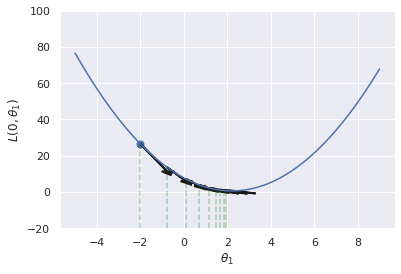

In [74]:
plot(theta_1, L_theta_1)
theta1_0 = -2
scatter(theta1_0, L(X, y, 0, theta1_0), s=50)

alpha = 0.1
for i in range(8):
    arrow(theta1_0, L(X, y, 0, theta1_0),
          -alpha*gradL(X, y, 0, theta1_0), -alpha*gradL(X, y, 0, theta1_0)**2,
          linewidth=2, head_width=0.5, head_length=2, fc='k', ec='k')
    vlines(x=theta1_0, ymin=-20, ymax=L(X, y, 0, theta1_0), color='green', alpha=0.3, linestyles='--')
    # text(x=theta1_0-0.45, y = -35, text='$\\theta_1^{(%d)}$' % i, s=50)
    theta1_0 += -alpha*gradL(X, y, 0, theta1_0)
vlines(x=theta1_0, ymin=-20, ymax=L(X, y, 0, theta1_0), color='green', alpha=0.3, linestyles='--')
ylim(-20, 100)
xlabel('$\\theta_1$')
ylabel('$L(0, \\theta_1)$');

Вернемся к двумерному случаю и проиллюстрируем работу метода градиентного спуска с помощью линий уровня.

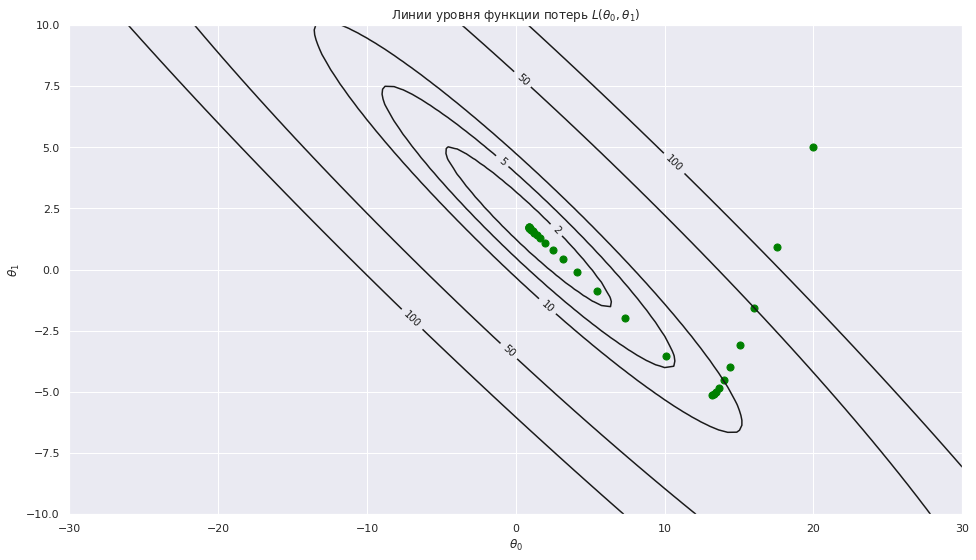

In [75]:
plt.figure(figsize=(16,9))
CS = plt.contour(theta_0v, theta_1v, L_theta, levels, colors='k')
plt.clabel(CS, inline=1, fontsize=10, colors='k')
plt.xlabel('$\\theta_0$')
plt.ylabel('$\\theta_1$')
plt.title('Линии уровня функции потерь $L(\\theta_0, \\theta_1)$')

def gradL(X, y, theta_0, theta_1):
    n = len(X)
    h = theta_0 + theta_1*X.values
    return (1/(n)*np.sum(h - y.values),
            1/(n)*np.sum(X.transpose()@(h - y.values)))

theta0_i = 20
theta1_i = 5

alpha = 0.1
for i in range(1000):
    upd_theta0_i, upd_theta1_i = gradL(X, y, theta0_i, theta1_i)
    if i < 10 or i % 50 == 0:
        scatter(theta0_i, theta1_i, s=50, c='green')
    theta0_i -= alpha*upd_theta0_i
    theta1_i -= alpha*upd_theta1_i

### Выражения для градиентов

Для реализации метода нам необходимо в явном виде вычислить частные производные функции потерь.
$$
\frac{\partial L}{\partial \theta_0} = \frac{1}{n}\sum\limits_{i=1}^n (h_\theta(x^{(i)}) - y^{(i)}) \\
\frac{\partial L}{\partial \theta_1} = \frac{1}{n}\sum\limits_{i=1}^n (h_\theta(x^{(i)}) - y^{(i)})x^{(i)} \\
$$
Здесь использовано правило вычисления производной для составной функции.

Используя данное представление мы уже нашли выше оценку для минимума функции $L$. Координаты этой точки равны

In [76]:
print("theta_0* = {:g}, theta_1* = {:g}".format(theta0_i, theta1_i))

theta_0* = 0.848754, theta_1* = 1.73993


Функция потерь при данном значении параметров принимает значение

In [77]:
L(X, y, theta0_i, theta1_i)

0.5626911771790485

Построим график для полученной гипотезы

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


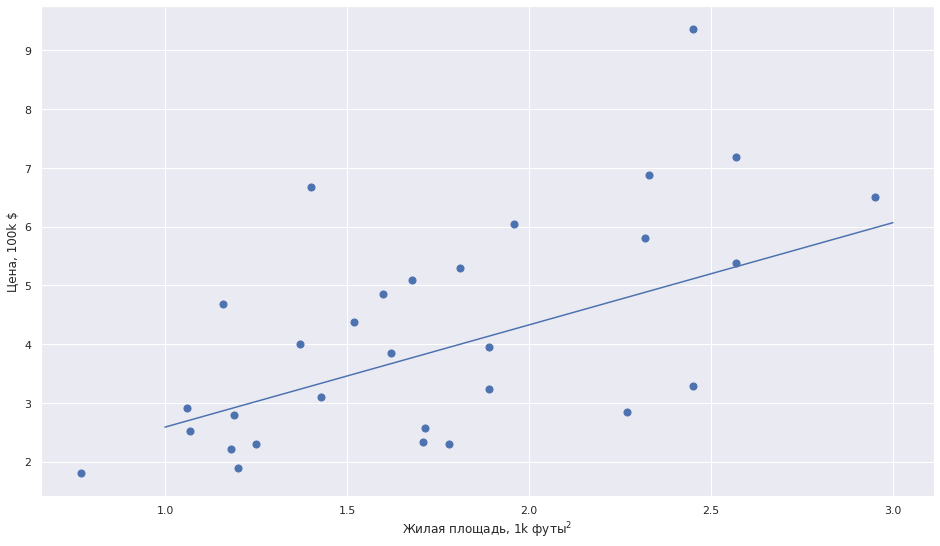

In [78]:
ax = housesales.plot.scatter(x='sqft_living', y='price', s=50, figsize=(16,9))
ax.set_xlabel('Жилая площадь, 1k футы$^2$')
ax.set_ylabel('Цена, 100k $')

xx = np.linspace(1, 3, 2)
plot(xx, theta0_i + theta1_i * xx);

In [79]:
X_test = test.sqft_living
y_test = test.price
y_pred = theta0_i + theta1_i * X_test

r2_linreg = r2_score(y_test, y_pred)
r2_linreg

0.009369585718064122

И вернемся к вопросу, который мы можем задать этой модели. Какова примерная стоимость дома площадью 2000 квадратных футов?

In [80]:
print("Примерная стоимость: {:.2g} * 100k$".format((theta0_i + theta1_i * 2)))

Примерная стоимость: 4.3 * 100k$


## Сохраняем коэффициенты модели

In [81]:
print(theta0_i, theta1_i)

0.8487542763699397 1.739934247832123


## Генерируем тестовые данные

In [82]:
ds_sample = housesales.sample(10)
X_sample = ds_sample['sqft_living']
y_pred = theta0_i + theta1_i * X_sample

test_data = np.hstack((y_pred.values.reshape(-1, 1), X_sample.values.reshape(-1, 1)))
np.savetxt("test_data_linreg.csv", test_data, fmt="%g")

In [83]:
!cat test_data_linreg.csv

3.23246 1.37
4.8854 2.32
3.33686 1.43
3.82404 1.71
5.11159 2.45
3.83274 1.715
3.63265 1.6
2.1885 0.77
4.13723 1.89
4.13723 1.89


### Основные результаты

Поздравляю! С помощью метода линейной регресии мы смогли построить систему машинного обучения, которая на основе предоставленных данных делает оценку для стоимости жилья. Для закрепления материала приведем еще раз основные понятия

* задача регрессии (regression problem) - задача машинного обучения, в которой по заданому входу нужно предсказать значение из множества вещественных чисел.
* объекты (objects)- сущности, для которых алгоритм делает предсказания
* признаки (features) - числовое представление объектов
* матрица объекты-признаки  - матрица по строкам которой отложены объекты, а по столбцам - признаки
* целевая  переменная (target) - значение, которое необходимо предсказать
* обучающая выборка (training set)- множество пар (объект, значение целевой переменной), которые используются для выбора модели
* линейная регрессия (linear regression) - метод решения задачи регрессии
* гипотеза (hypothesis) - вид функции, которая используется для нахождения целевой переменной
* параметры гипотезы (hypothesis parameters) - неизвестные величины, которые необходимо найти в ходе обучения
* функция потерь (loss function) - штраф за неправильный результат
* градиентный спуск (gradient descent) - метод решения задачи оптимизации, который базируется на использовании градиента функции
* срокость обучения (learning rate) - основной параметр метода градиентного спуска, который отвечает за скорость сходимости

Далее мы рассмотрим как динейную регресси можно обобщить на случай произвольной размерности и что можно сделать с явно нелинейными зависимостями.

## Многомерная линейная регрессия

В случае, если целевай переменная зависит от нескольких признаков, например, площадь дома и цисло ванных комнат, линейную регрессию можно обобщить на случай многмерного вектора признаков.

Рассмотрим задачу прогноза цены жилья в зависимости от следующих параметров:
 * количество спальных комнат
 * количество ванных комнат
 * жилая площадь
 * общая площадь
 * количество этажей
 * год постройки

In [84]:
KC_HOUSE_DATA_URL = 'https://gist.github.com/sdukshis/b98e467996e6019f7858b36c2d4643bf/raw/cf999800519c8121e6ac43d7159d0a5026ab6fbf/kc_house_data.csv'
housesales = pd.read_csv(KC_HOUSE_DATA_URL)
housesales['SalePrice'] = housesales['SalePrice']/100000
housesales.head()

,SalePrice,LotArea,LotFrontage,1stFlrSF,OverallQual,GarageArea,YearBuilt,TotalBsmtSF,2ndFlrSF
0,2.085,8450,65.0,856,7,548,2003,856,854
1,1.815,9600,80.0,1262,6,460,1976,1262,0
2,2.235,11250,68.0,920,7,608,2001,920,866
3,1.400,9550,60.0,961,7,642,1915,756,756
4,2.500,14260,84.0,1145,8,836,2000,1145,1053


Предствим матрицу объекты-признаки как
$$
X = \begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m}  \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{nm} \\
\end{pmatrix}
$$

Здесь $n$ - число объектов и $m$ - число признаков.

Вектор целевых переменных $y$ имеет ту же форму, что и для одного признака
$$
y = \begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix}
$$

Для многомерного случая гипотеза $h_\theta(x)$ пример следующий вид
$$
h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \cdots + \theta_mx_m.
$$

Из приведенного веше выражения видно, что слагаемое $\theta_0$ отличается от всех остальных, которые представляют собой произведения различных компанент вектора параметров $\theta$ и вектора признаков $x = (x_1, x_2 , \dots, x_m)$. Чтобы привести выражение для гипотезы к более простому виду мы применим следующий приём. Расширим матрицу объекты-признаки дополнительным столбцом слева, состоящим из одних единиц
$$
X = \begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1m} \\
1 & x_{21} & x_{22} & \cdots & x_{2m}  \\
\vdots & \vdots & & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{nm} \\
\end{pmatrix}
$$
и используем нулевой индекс для обозначения этого столбца ($x_{i0} = 1, \quad i = \overline{1, n}$).

Тогда выражение для гипотезы $h_\theta(x)$ можно переписать в виде
$$
h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \cdots + \theta_mx_m = \theta_0x_0 + \theta_1x_1 + \theta_2x_2 + \cdots + \theta_mx_m = \sum\limits_{i = 0}^{m}\theta_ix_i = \theta^Tx.
$$
Т.е. представить в виде скалярного произведения ветора параметров $\theta$ и вектора признаков $x$. Здесь и далее под матрицей объектов-признаков $X$ будем понимать расширенную матрицу с единичным первым столбцом.

В качестве функции потерь $L$ как и прежде рассмотрим средний квадрат ошибки
$$
L(\theta) = \frac{1}{2n}\sum\limits_{i=1}^{n}\left(h_\theta(x^{(i)}) - y^{(i)}\right)^2.
$$

Здесь с помощью $x^{(i)} = (x_{i0}, x_{i1}, \dots, x_{im})^T$ обозначена вектор, составленый из строки матрицы $X$.

### Векторная форма градиентного спуска

Рассмотрим как метод градиентного спуска можно обобщить на многомерный случай. Для этого вычислим градиент фукнци потерь $J$ по всем компонентам вектора параметров $\theta$.

$$
\frac{\partial L}{\partial \theta_0} = \frac{1}{n}\sum\limits_{i=1}^n (h_\theta(x^{(i)}) - y^{(i)}) \\
\frac{\partial L}{\partial \theta_j} = \frac{1}{n}\sum\limits_{i=1}^n (h_\theta(x^{(i)}) - y^{(i)})x_{ij}, \quad j = \overline{1, m} \\
$$

Или, используя прием с дополнительным единичным столбцом ($x_{i0} = 1$), можно переписать выражением для компонент вектора градиента в единообразном стиле
$$
\frac{\partial L}{\partial \theta_j} = \frac{1}{n}\sum\limits_{i=1}^n (h_\theta(x^{(i)}) - y^{(i)})x_{ij}, \quad j = \overline{0, m} \\
$$

Наконец, в векторном виде выражение для градиента пример вид
$$
grad~ L(\theta) = \frac{1}{n} X^T(X\theta - y).
$$

Уравнение для обновления параметров $\theta$ для шага градиентного спуска можно также представить в вектрном виде
$$
\theta^{(k+1)} = \theta^{(k)} - \alpha ~grad ~ L(\theta^{(k)}).
$$


### Кривая обучения

В многомерном случае не представляется возможным визуализировать работу метода градиентного спуска с помощью линий уровня, поскольку простанство параметров в общес случае имеет размерность $m+1$. На помощь нам приходит другое представление, которое показывается изменение значений функции потерь в точке $\theta^{(k)}$ в зависимости от номера шага $k$. Такой график называется кривой обучения.

#### Проведем предобработку данных

In [85]:
from sklearn.model_selection import train_test_split
n = len(housesales)
m = len(housesales.drop('SalePrice', axis=1).columns)
y = housesales['SalePrice'].values.reshape((n, 1))
X = housesales.drop('SalePrice', axis=1).values.reshape((n, m))
X = np.hstack((np.ones((n, 1)), X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Градиентный спуск

In [86]:
def grad(y, X, theta):
    n = y.shape[0]
    return 1/n * X.transpose() @ (X @ theta - y)

def L(y, X, theta):
    n = y.shape[0]
    return 1/(2*n)*np.sum(np.power(X @ theta - y, 2))

def fit(y, X, theta_0, alpha=0.001, nsteps = 100):
    theta = np.copy(theta_0)
    loss = [L(y, X, theta)]
    for i in range(nsteps):
        theta -= alpha*grad(y, X, theta)
        loss.append(L(y, X, theta))
    return loss, theta

In [87]:
theta_0 = np.zeros((m + 1, 1))
loss_history, theta_star = fit(y_train, X_train, theta_0, alpha=1e-10, nsteps=10000)

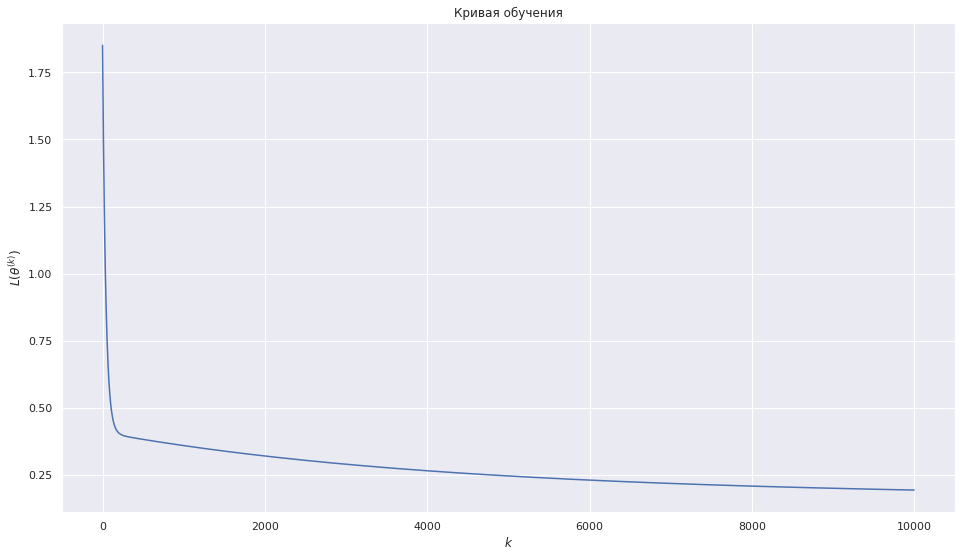

In [88]:
plt.figure(figsize=(16,9))
plt.plot(loss_history)
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
_ = plt.title('Кривая обучения')

In [89]:
L(y_train, X_train, theta_star)

0.1933029497967609

In [90]:
y_pred = X_test @ theta_star
r2_linreg_multi = r2_score(y_test, y_pred)
r2_linreg_multi

0.12962806738280575

## Сохраняем коэффициенты и тестовые данные

In [91]:
np.savetxt("linreg_multi_coef.txt", theta_star)

In [92]:
ds_sample = housesales.sample(10)
features = ds_sample.drop('SalePrice', axis=1)
X_sample = np.hstack((np.ones((features.shape[0], 1)), features))
y_pred = X_sample @ theta_star

test_data = np.hstack((y_pred.reshape(-1, 1), features.values))
np.savetxt("test_data_linreg_multi.csv", test_data, fmt="%g")

In [93]:
!cat test_data_linreg_multi.csv

1.47946 10200 60 672 5 240 1940 672 0
1.81173 9675 75 1113 7 689 2005 1113 858
3.37392 35133 50 1572 5 995 1963 1572 0
1.50868 8480 80 832 5 336 1947 832 384
1.94338 13000 100 1182 6 509 1968 896 960
1.36684 6120 51 1015 5 450 1925 768 0
1.90958 10665 72 1479 7 558 2003 1453 0
1.29483 2522 24 970 6 380 2004 970 739
1.38777 8777 67 1126 4 520 1949 0 0
2.09284 10159 83 1940 9 606 2009 1930 0


Стоит обратить внимание, что наблюдается очень медленная сходимость метода градиентного спука для такой постановки задачи. Попробуем решить эту проблему с помощью предобработчки данных, а конкретно - нормализации признаков.

### Нормирование признаков

Поскольку различные признаки могу иметь отличные размерности, то, для устойчисвости численной процедуры метода градиентного спуска, рекомендуется провести их нормализацию. Для этого каждый признак можно по отдельности нормировать, вычтя из него среднее значение и разделив на средне-квадратичное отклонение
$$
    U^{(j)} = \frac{X^{(j)} - M[X^{(j)}]}{\sqrt{D[X^{(j)}]}}, \quad j = \overline{1, m}.
$$

При этом первый столбце из одних единиц остается неизменным.
$$
    U^{(0)} = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1\end{pmatrix}
$$

In [94]:
U = np.ones(X_train.shape)
for j in range(1, X_train.shape[1]):
    U[:, j] = (X_train[:, j] - np.mean(X_train[:, j]))/np.std(X_train[:, j])
    

In [95]:
loss_history, theta_star = fit(y_train, U, theta_0, alpha=1e-1, nsteps=50)

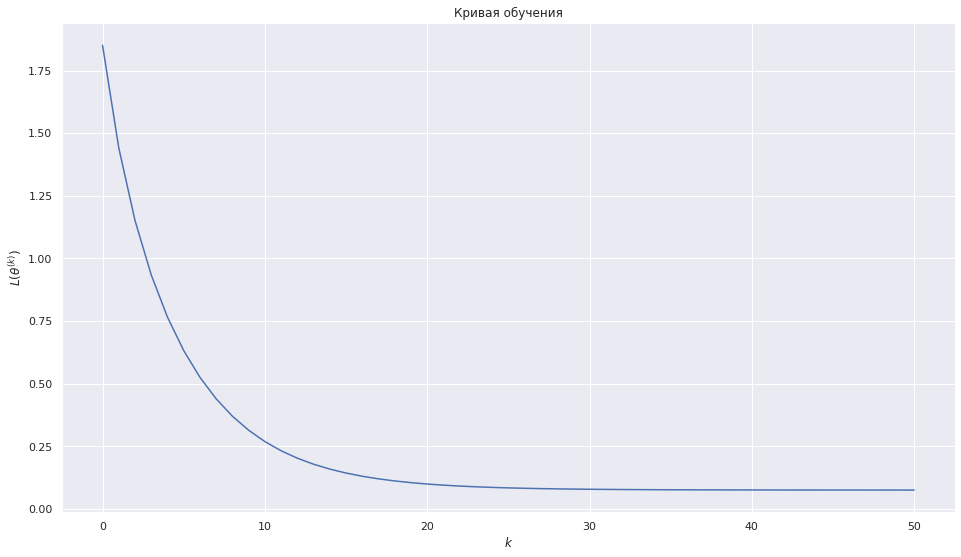

In [96]:
plt.figure(figsize=(16,9))
plt.plot(loss_history)
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
_ = plt.title('Кривая обучения')

Из графика видно, что при нормализации признаков удалось достичь того же значения функции потерь сделав в 10 раз меньше шагов.

Значение функции потерь для нашей задачи составило

In [97]:
L(y_train, U, theta_star)

0.07531069641828494

Для признаков из тестовой выборки также нужно провести нормировку. При этом следует использовать только значения среднего и стандартного отклонения, полученные из обучающей выборки

In [98]:
U_test = np.ones(X_test.shape)
for j in range(1, m + 1):
    U_test[:, j] = (X_test[:, j] - np.mean(X_train[:, j]))/np.std(X_train[:, j])
y_pred = U_test @ theta_star
r2_linreg_multi = r2_score(y_test, y_pred)
r2_linreg_multi

0.7813791846233407

Как же можно улучшить этот результат оставаясь в рамках метода линейно регрессии? 

## Сохраняем коэффициенты и тестовые данные

In [99]:
np.savetxt("linreg_norm_coef.txt", theta_star)
np.savetxt("linreg_norm_mean.txt", np.mean(X_train[:, 1:], axis=0))
np.savetxt("linreg_norm_std.txt", np.std(X_train[:, 1:], axis=0))

In [100]:
ds_sample = housesales.sample(10)
features = ds_sample.drop('SalePrice', axis=1)
X_sample = np.hstack((np.ones((features.shape[0], 1)), features))
U_sample = np.ones((features.shape[0], features.shape[1] + 1))
for j in range(1, X_sample.shape[1]):
    U_sample[:, j] = (X_sample[:, j] - np.mean(X_train[:, j]))/np.std(X_train[:, j])
y_pred = U_sample @ theta_star

test_data = np.hstack((y_pred.reshape(-1, 1), features.values))
np.savetxt("test_data_linreg_norm.csv", test_data, fmt="%g")

### Нелинейные зависимости

Проведем анализ нашей задачи. Для этого построим зависимость целевой переменной от каждого из признаков по отдельности.

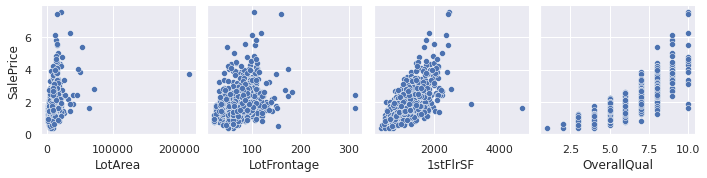

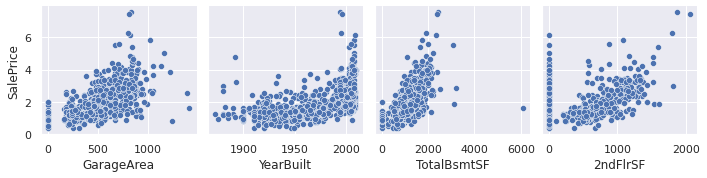

In [101]:
sns.pairplot(housesales, y_vars="SalePrice",
                 x_vars=["LotArea", "LotFrontage", "1stFlrSF", "OverallQual"],
            )
sns.pairplot(housesales, y_vars="SalePrice",
                 x_vars=["GarageArea", "YearBuilt", "TotalBsmtSF", "2ndFlrSF"],
            )

По характерному виду некоторых зависимостей можно предположить, что целевая переменная нелинейно зависит от некоторых признаков. Чтобы учеть подобные зависимости мы модем обогатить числовые признаки их квадратами и произведениями различных признаков, получив, таким образом, новую матрицу объекты-признаки.
$$
X = \begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1m} & x_{11}^2 & x_{11}x_{12} & \cdots & x_{1m}^2\\
1 & x_{21} & x_{22} & \cdots & x_{2m} & x_{21}^2 & x_{21}x_{22} & \cdots & x_{2m}^2 \\
\vdots & \vdots & & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{nm} & x_{n1}^2 & x_{n1}x_{n2} & \cdots & x_{nm}^2\\
\end{pmatrix}
$$

После чего используем тот же метод линейно регрессии.

In [102]:
X_train_poly = np.zeros((X_train.shape[0], (m + 1)**2))
for i in range(X_train.shape[0]):
    X_i = X_train[i,:].reshape(1, -1)
    X_train_poly[i, :] = (X_i.T @ X_i).reshape(-1)

In [103]:
n = len(housesales)
m = len(housesales.drop('SalePrice', axis=1).columns)
y = housesales['SalePrice'].values.reshape((n, 1))

tmpX = np.ones((n, m + 1))
X = np.zeros((n, (m + 1)**2))
tmpX[:, 1:] = housesales.drop('SalePrice', axis=1).values.reshape((n, m))
for i in range(n):
    X_i = tmpX[i, :] .reshape(1, -1)
    X[i, :] = (X_i.T @ X_i).reshape(-1)

In [104]:
U_train = np.ones(X_train_poly.shape)
for j in range(1, X_train_poly.shape[1]):
    U_train[:, j] = (X_train_poly[:, j] - np.mean(X_train_poly[:, j]))/np.std(X_train_poly[:, j])

In [105]:
theta_0 = np.zeros((U_train.shape[1], 1))
loss_history, theta_star = fit(y_train, U_train, theta_0, alpha=1e-2, nsteps=500)

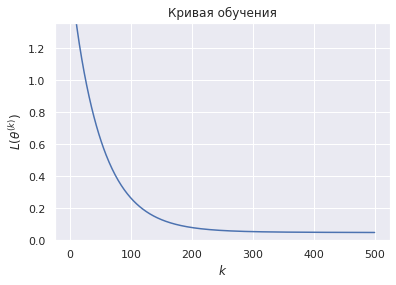

In [106]:
plt.plot(loss_history)
plt.ylim((0, loss_history[10]))
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
_ = plt.title('Кривая обучения')

Значение функции потерь после процедуры градиентного спуска равно

In [107]:
L(y_train, U_train, theta_star)

0.048914579200689486

что немного улучшает результат, полученный без использования квадратичных признаков.

In [108]:
X_test_poly = np.zeros((X_test.shape[0], (m + 1)**2))
for i in range(X_test_poly.shape[0]):
    X_i = X_test[i,:].reshape(1, -1)
    X_test_poly[i, :] = (X_i.T @ X_i).reshape(-1)

U_test = np.ones(X_test_poly.shape)
for j in range(1, X_test_poly.shape[1]):
    U_test[:, j] = (X_test_poly[:, j] - np.mean(X_train_poly[:, j]))/np.std(X_train_poly[:, j])
y_pred = U_test @ theta_star
r2_linreg_poly = r2_score(y_test, y_pred)
r2_linreg_poly

0.8134038591815587

## Резюме

1. Метод линейной регрессии может быть расширен на многомерный случай
2. Для улучшения сходимости метода градиентного спуска следует использовать нормализацию признаков
3. Метод линейной регрессии можно обобщить на нелинейный случай с помощью добавления полиномиальных признаков
4. Аналитическое решения задачи линейной регресии называется **нормальное уравнение**
5. Аналитическое решение следует использовать при числи признаков меньше либо равном 1000

## Источники

1. **Andrew Ng**. Machine Learning - [Linear regression with one variable](https://www.coursera.org/learn/machine-learning/home/week/1), [Linear regression with multiple variables](https://www.coursera.org/learn/machine-learning/home/week/2)
2. **К. В. Воронцов**. Введение в машинное обучение - [Линейна регрессия](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/home/week/4)
3. **Christopher M. Bishop**. Pattern Recognition And Machine Learning - [Linear models for regression]
4. Открытй курс по машинному обучению - [Линейные модели классификации и регрессии](https://habrahabr.ru/company/ods/blog/323890/)